# All Required Imports and Global Vars. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.ndimage as nd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
import os
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
import time
from scipy.ndimage.measurements import label
import warnings
warnings.filterwarnings('ignore')
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from skimage import exposure
# Visualizations will be shown in the notebook.
%matplotlib inline

global orient, pix_per_cell,cell_per_block,spatial_size,hist_bins,svc,X_scaler,X,y,BTracker,frame_count

/home/sourav/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sourav/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# # Class Definition and Instantiation for Video Processing

In [2]:
class BoxTracker():
    '''
    This class keeps track of all boxes detected over the last
    55 frames of the video sequence and provides the heatmap
    over all detected boxes over stored frames.
    '''
    def __init__(self):
        self.aggregated_frame_count = 0
        self.frame_boxes = []
    
    def get_frame_count(self):
        return self.aggregated_frame_count

    def append_boxes(self,boxes):
        #Only last 50 boxes for last frames are stored
        if(self.aggregated_frame_count == 50):
            del self.frame_boxes[0]
            self.aggregated_frame_count-=1
        
        #Store the found boxes
        self.frame_boxes.append(boxes)
        self.aggregated_frame_count+=1
    
    def getheat(self,img):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        #Add heat for all the windows detected per frame
        #for all frames in storage
        for box in self.frame_boxes:
            heat = add_heat(heat,box)
        
        #Perform thresholding for the heatmap
        #to remove areas that are not part of atleast
        #8 detected boxes over all frames.
        heat = apply_threshold(heat,8)
        return heat

#Instantiate the class.
BTracker = BoxTracker()

## Import the Vehicle and Non-Vehicle Data from Data-Set.

In [64]:
#Load vehicle data
X = []
y = [] #Label 0 for non-vehicle and Label 1 for vehicle
images_v = []
images_v_src1 = glob.glob('vehicles/GTI_Far/*.png')
images_v_src2 = glob.glob('vehicles/GTI_Left/*.png')
images_v_src3 = glob.glob('vehicles/GTI_MiddleClose/*.png')
images_v_src4 = glob.glob('vehicles/GTI_Right/*.png')
images_v_src5 = glob.glob('vehicles/KITTI_extracted/*.png')

#Some shuffling to disrupt time-series sequential nature of dataset
images_v  = images_v_src1 + images_v_src2 + images_v_src3 + images_v_src4 + images_v_src5
random.shuffle(images_v)

print(len(images_v))
for f_img in images_v:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X.append(img)
    y.append(1)

#Load Non-Vehicle Data
images_nv = []
images_nv_src1 = glob.glob('non-vehicles/Extras/*.png')
images_nv_src2 = glob.glob('non-vehicles/GTI/*.png')

#Some shuffling to disrupt time-series sequential nature of dataset.
images_nv = images_nv_src1 + images_nv_src2
random.shuffle(images_nv)
print(len(images_nv))

for f_img in images_nv:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X.append(img)
    y.append(0)

#Total Dataset is now available.
X = np.array(X)
y = np.array(y)
print(X.shape)

X,y = shuffle(X,y)   


8792
8968
(17760, 64, 64, 3)


# All Helper functions

In [5]:
def convert_color(img, conv='RGB2YCrCb'):
    '''
    This functions performs colour conversion to the desired color space    
    '''
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''
    This function returns HOG features(and HOG Image if needed) for the
    input image channel
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    '''
    This function returns the Spatially binned features
    for the input image for all channels after resizing
    to the required size.
    '''
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    '''
    This function returns the Colour Histogram
    features of the input image.
    '''
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features


def find_cars_v3(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                 spatial_size, hist_bins,xstart,vis=False):
    
    '''
    This function collects HOG + Spatial Binned + Channel Historgram features for all input scales
    of the input image and does the following:
    For each input scale:
    a) First it obtains the section of image to search based on specified values of ystart,ystop,xstart
    b) It converts the subimage to the required color space here its YCrCb and scales it.
    c) Obtains HOG features per channel for the scaled image.
    d) Performs HOG subsamling based Window search where it extracts the HOG features in the current window
       and concatenates it with the Spatial Binned and Colour Histogram features and makes a prediction.
    e) If the Prediction is a car and satisfies the decision score threshold,
       it appends the detected box corners to a temporary list.
    For all found boxes for all scales, it calculates a heatmap and calculates the labels and finally returns
    the final result with drawn boxes on detected objects.
    
    I.e. Even though multiple boxes are found around each object for various input scales, it performs a Union of
    all found boxes and returns one box enclosing each predicted Car.    
    '''
    boxes = []
    draw_img = np.copy(img)
    scale_wdw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    
    for scale in scales:
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        hog_img = np.zeros_like(ctrans_tosearch).astype(np.float)

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient*cell_per_block**2
        
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        
        # Compute individual channel HOG features for the entire image
        if vis == True:
            hog1,hog_img[:,:,0] = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis,feature_vec=False)
            hog2,hog_img[:,:,1] = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis,feature_vec=False)
            hog3,hog_img[:,:,2] = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis,feature_vec=False)
        else:
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                
                # Get Color Histogram features
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))   
            
                #Perform the prediction
                test_prediction = svc.predict(test_features)
                
                #Calculate the Decision Score
                dec_score = abs(svc.decision_function(test_features))
            
                #Only if the prediction is a car and the prediction's decision score
                #is higher than 1.1, consider it as a detection and save relevant params.
                if ( test_prediction == 1 and dec_score >= 1.1 ):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(scale_wdw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),
                                 (0,0,255),6)
    
    #All detected vehicle boxes across all scales are available now.
    #Calculate the heatmap for all detected boxes.
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)
    
    heatmap = np.clip(heat, 0, 255)
    
    boxes = []   
    #Caculate labels from heatmap and
    # Find final boxes
    labels = label(heatmap)
    for obj in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == obj).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(draw_img,(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)),(0,0,255),6)
        boxes.append(bbox)
    
    #Returns 1 box per predicted vehicle, Image with final boxes drawn on the predicted cars,
    #Image with all boxes drawn on the predicted cars, Image with HOG features for the ROI
    return boxes,draw_img,scale_wdw_img,hog_img,labels

def add_heat(heatmap, bbox_list):
    '''
    This function generates the heatmap for the set of
    input boxes.
    '''
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    '''
    This function performs thresholding on the heatmap
    regions whose count is lesser than the desired threshold
    and sets them to 0. This has been utilized only for Video
    Processing to peform heatmap thresholding across detected frame
    boxes.
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    '''
    This function draws boxes on the detected objects.
    '''
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def train_data():
    '''
    This function performs the Training over the input data-set by:
    a) Extracting the HOG + Spatial Binned Features + Colour Hist Features for each input image.
    b) Splitting the entire Feature-Set into training and Test Feature-Set.
    c) Fitting a Standard Scaler on the training feature-set and Standard Scaling the Training and Test Feature set.
    d) Performing training using a LinearSVC and saves the params to a pickle file for later use.
    '''
    
    global orient, pix_per_cell,cell_per_block,spatial_size,hist_bins,svc,X_scaler,X,y
    
    features_l = []
    #Set parameter values
    orient = 9
    pix_per_cell = 16
    cell_per_block = 2
    spatial_size = 16
    hist_bins = 32

    #Extract features for all the images
    for i in range(0,X.shape[0]):
        img = convert_color(X[i], conv='RGB2YCrCb')
        #Collect Hog-features channel wise
        hog_ch1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
        hog_ch2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
        hog_ch3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
    
        hog_feat = np.hstack((hog_ch1,hog_ch2,hog_ch3))

    
        #Collect Spatial binned features and Histogram bin features
        spatial_features = bin_spatial(img,size=(spatial_size,spatial_size))

        hist_features = color_hist(img,hist_bins)
    
        features = np.hstack((spatial_features,hist_features,hog_feat)).reshape(1,-1)
        features_l.append(list(features))

    #Standard scaling of all the features
    features_l = np.array(features_l)
    features_l = np.squeeze(features_l)
    print(features_l.shape)

    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_l, y, test_size=0.2, random_state=22)

    #Scale the Data set- Training or test after
    #fitting the Scaler to the Training data-set.
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    #Start Training
    svc = LinearSVC(loss='hinge') # Use a linear SVC 
    t=time.time() # Check the training time for the SVC
    svc.fit(X_train, y_train) # Train the classifier
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC
    
    #Write Data to Pickle File
    # Save the data for easy access
    pickle_file = 'data2.p'
    print('Saving data to pickle file')
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'svc': svc,
                'X_scaler': X_scaler,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block':cell_per_block
            },
            pfile, pickle.HIGHEST_PROTOCOL)


def process_frame(img):
    '''
    This function processes each frame of the video, finds boxes for each predicted vehicle, stores
    those boxes in class storage, retrieves the heatmap of the currently stored set of boxes in class
    storage, finds labels for the heatmap and outputs a resultant image with labelled boxes drawn on top
    of the input frame.
    '''
    global orient, pix_per_cell,cell_per_block,spatial_size,hist_bins,svc,X_scaler,BTracker,frame_count
    
    #Debugging parameters disabled for final implementation.
    file_writing = False
    frame_count+=1
    
    scales = []
    for s in range(65,215,20):
        scales.append(s*0.01)

    ystart = np.int(img.shape[0]/2)
    ystop = img.shape[0]
    xstart = 250
    boxes,rect_img,_,_,labels_f = find_cars_v3(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                        (spatial_size,spatial_size), hist_bins,xstart)
    
    if file_writing == True:
        str1 = 'one_f_boxes/' + str(frame_count) + '.jpg'
        cv2.imwrite(str1,cv2.cvtColor(rect_img,cv2.COLOR_RGB2BGR))
    
    if file_writing == True:
        c_str = 'labels_vid/' + str(frame_count) + '.png'
        plt.imsave(c_str,labels_f[0])
    
    #Save found boxes for this frame to Class Storage.
    BTracker.append_boxes(boxes)
    
    #Obtain thresholded heatmap over all aggregated boxes in Class Storage
    heat = BTracker.getheat(img)
    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    if file_writing == True:
        c_str = 'labels_agg/' + str(frame_count) + '.png'
        plt.imsave(c_str,labels[0])
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if file_writing == True:
        str1 = 'res_boxes/' + str(frame_count) + '.jpg'
        cv2.imwrite(str1,cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR))
    
    return draw_img

# Perform Training

In [66]:
#Training Phase:
#Perform Training
train_data()

(17760, 1836)
3.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
Saving data to pickle file


# Retrieve saved paramters from Pickle file.

In [4]:
# Load the classifier and parameters
data_file = 'data2.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']

# Analyze performance on test-Image set.

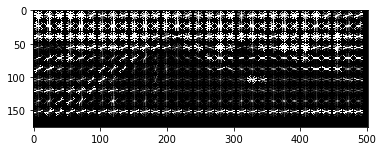

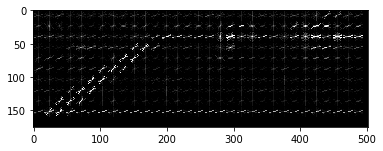

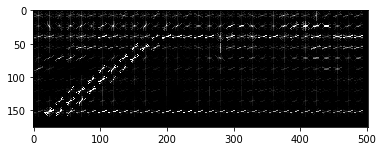

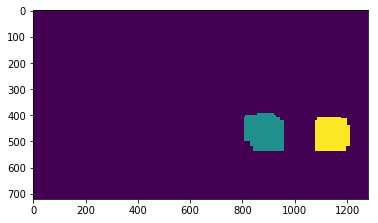

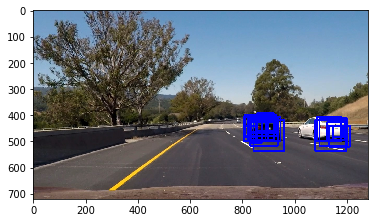

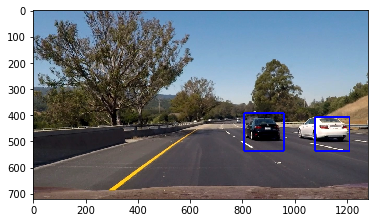

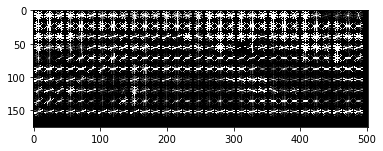

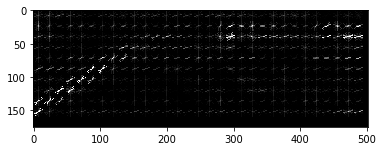

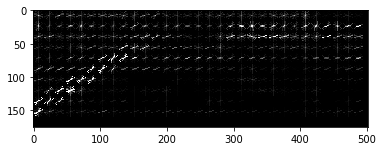

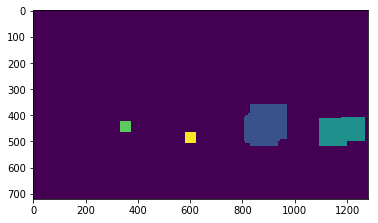

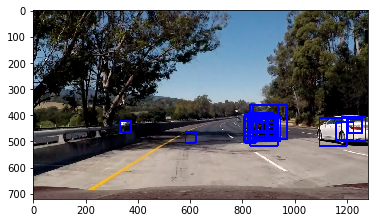

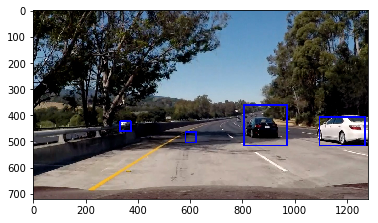

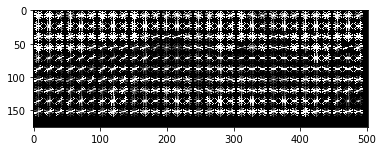

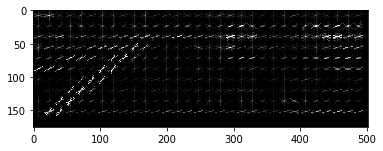

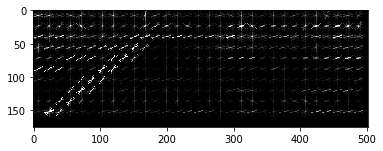

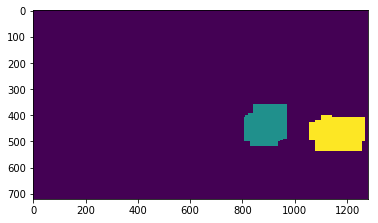

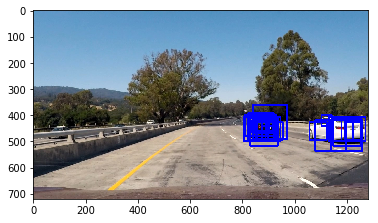

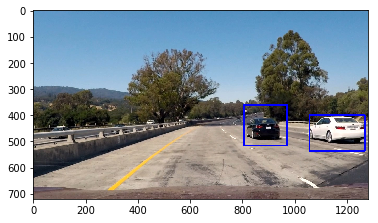

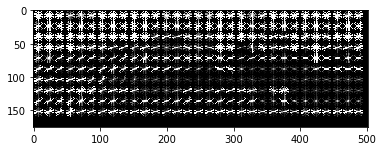

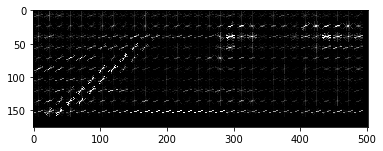

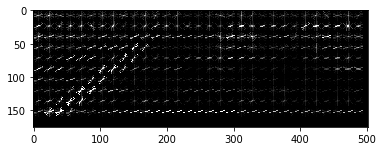

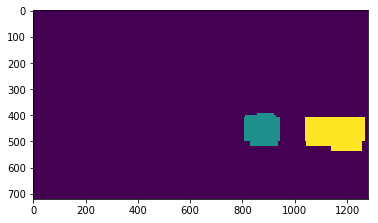

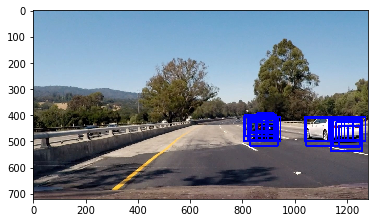

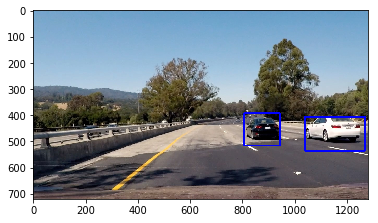

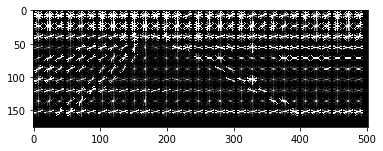

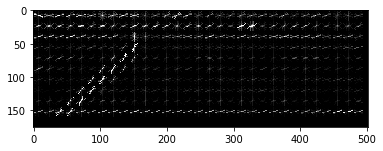

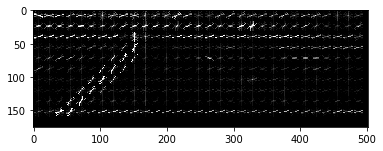

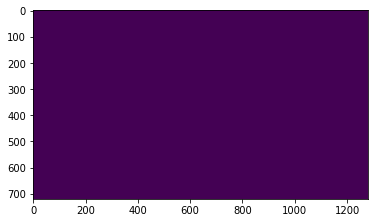

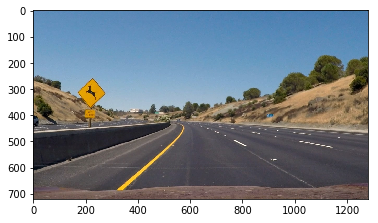

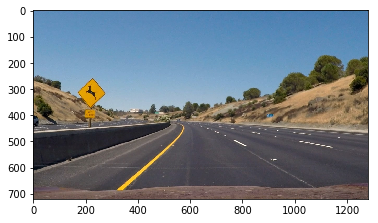

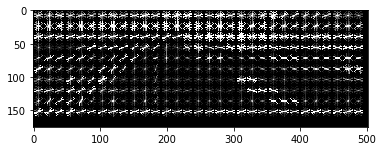

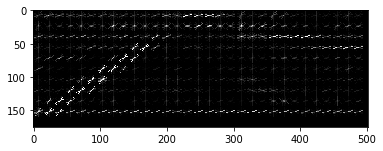

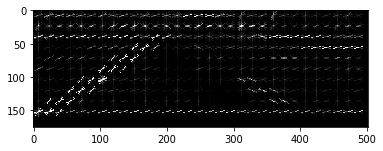

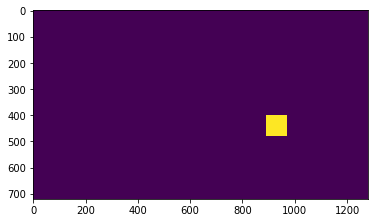

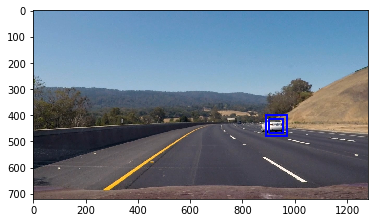

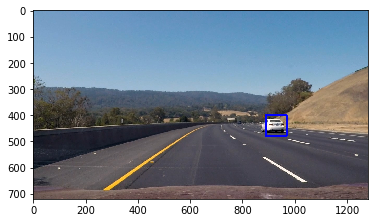

In [56]:
#Operations on test-images
scales = []
for s in range(65,215,20):
    scales.append(s*0.01)

images_test = glob.glob('test_images/*.jpg')
for f_img in images_test:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ystart = np.int(img.shape[0]/2)
    ystop = img.shape[0]
    xstart = 250
    boxes,rect_img,scaled_wdw_img,hog_img,labels = find_cars_v3(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                                                (spatial_size,spatial_size), hist_bins,xstart,vis=True)
    
    # Rescale intensity of hog image for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 1))
    
    #Show the HOG features extracted over all channels
    plt.imshow(hog_image_rescaled[:,:,0],cmap='gray')
    plt.figure()
    
    plt.imshow(hog_image_rescaled[:,:,1],cmap='gray')
    plt.figure()
    
    plt.imshow(hog_image_rescaled[:,:,2],cmap='gray')
    plt.figure()
    
    c_str_y = 'hog_img/' + 'CH_Y' + (f_img.split('/')[-1]).split('.')[0] + '.png'
    c_str_cr = 'hog_img/' + 'CH_Cr' + (f_img.split('/')[-1]).split('.')[0] + '.png'
    c_str_cb = 'hog_img/' + 'CH_Cb' + (f_img.split('/')[-1]).split('.')[0] + '.png'
    plt.imsave(c_str_y,(hog_image_rescaled[:,:,0]))
    plt.imsave(c_str_cr,(hog_image_rescaled[:,:,1]))
    plt.imsave(c_str_cb,(hog_image_rescaled[:,:,2]))
    
    #Show the labels output
    plt.imshow(labels[0])
    plt.figure()
    c_str = 'labels/' + (f_img.split('/')[-1]).split('.')[0] + '.png'
    plt.imsave(c_str,labels[0])
   
    #Show the image with windows detected over all scales
    plt.imshow(scaled_wdw_img)
    plt.figure()
    scaled_wdw_img = cv2.cvtColor(scaled_wdw_img, cv2.COLOR_RGB2BGR)
    c_str = 'scaled_wdw_img/' + f_img.split('/')[-1]
    cv2.imwrite(c_str,scaled_wdw_img)
    
    #Show the final image after window suppression
    plt.imshow(rect_img)
    plt.figure()
    rect_img = cv2.cvtColor(rect_img, cv2.COLOR_RGB2BGR)
    c_str = 'final_boxed_img/' + f_img.split('/')[-1]
    cv2.imwrite(c_str,rect_img)

# Video Processing

In [6]:
frame_count = 0
white_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(16,30)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [1:13:34<00:03,  3.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 1h 47min 7s, sys: 1min 20s, total: 1h 48min 28s
Wall time: 1h 13min 35s
